In [141]:
import numpy as np
import cupy as cp
import math
import random
import matplotlib.pyplot as plt

class BasicGate: # 1-qubit gate
  def __init__(self, params=None):
    if params is None:
      params = [0, 0]
    self.params = params
    # Pauli matrices
    self.I = np.eye(2, dtype=complex)
    self.X = np.asarray([[0, 1], [1, 0]], dtype=complex)
    self.Y = np.asarray([[0, -1j], [1j, 0]], dtype=complex)
    self.Z = np.asarray([[1, 0], [0, -1]], dtype=complex)

  @property
  def matrix(self): # straightforward matrix representation
    matrix = math.cos(self.params[0] / 2) * self.I - 1j * math.sin(self.params[0]/2) * (math.cos(self.params[1]) * self.X + math.sin(self.params[1]) * self.Y)

    return matrix

  def randomize_params(self):
    self.params = [2 * math.pi * random.random(), 2 * math.pi * random.random()]

  def correct_params(self, correction): # update parameters based on passed corrections
    self.params[0] += correction[0]
    self.params[1] += correction[1]


class EvolutionStep: # a combination of 1-qubit operations followed by evolution
  def __init__(self, size = 2, params=None):
    if params is None:
      params = []
    self.size = size # number of qubits
    self.time = 0.2 # evolution time

    if len(params) != self.size:
      params += [[0, 0] for _ in range(self.size - len(params))]

    self.basicGates = [BasicGate(param) for param in params] # 1-qubit gates

    self.J = np.zeros((2 ** self.size, 2 ** self.size), dtype=np.complex) # interaction matrix (NOT FINISHED)
    for i in range(self.size - 1):
      self.J[i + 1][i] = 1 # костыль

  @property
  def evolution(self): # evolution matrix
    if self.size == 2:
      second = -np.eye(2 ** self.size, dtype=np.complex)
      second[0][0] = 1
      second[3][3] = 1

      return math.cos(self.time / 2) * np.eye(2 ** self.size, dtype=np.complex) - 1j * math.sin(self.time / 2) * second
    return np.eye(2 ** self.size, dtype=np.complex) # NOT FINISHED

  @property
  def matrix(self): # unitary of this evolution step
    matrix = np.ones(1, dtype=np.complex)

    for i in range(self.size):
      matrix = np.kron(matrix, self.basicGates[i].matrix) # 1-qubit "kick"
    matrix = self.evolution @ matrix # evolution

    return matrix

  def randomize_params(self):
    for basicGate in self.basicGates:
      basicGate.randomize_params()

  def correct_params(self, correction, evolution_correction): # update parameters based on passed corrections
    for i in range(self.size):
      self.basicGates[i].correct_params(correction[i])
    self.time += evolution_correction


class Implementation: # class to approximate abstract unitary using a series of evolutionStep
  def __init__(self, target, n):
    self.target = target # unitary to approximate
    self.noise = 0.05 # noise levels (see self.stupidCalculateGradient)

    self.n = n # number of evolution steps
    self.size = int(math.log2(self.target.size) / 2) # number of qubits

    self.phase = 0 # global phase
    self.gates = [EvolutionStep(size=self.size) for _ in range(self.n)] # evolution steps

    self.evolutionGradient = [0] * self.n # -gradient of cost function by evolution times
    self.phaseGradient = 0 # -gradient of cost function by global phase
    self.gradient = [[[0, 0] for _ in range(self.size)] for _ in range(self.n)] # -gradient of cost function by 1-qubit operations parameters
    self.stepSize = 0.05 # parameter update by gradient coefficient for 1-qubit operations parameters and evolution times
    self.phaseStepSize = 0.01 # parameter update by gradient coefficient for global phase (diverges when trying to lower)

  @property
  def time(self): # total approximation time
    time = 0
    for gate in self.gates:
      time += gate.time
    return time.real

  @property
  def target_d(self): # target dagger
    return self.target.conjugate().transpose()

  @property
  def matrix(self): # approximation matrix
    matrix = np.eye(2**self.size, dtype=np.complex)

    for i in range(self.n):
      matrix = matrix @ self.gates[i].matrix * math.e ** (1j * self.phase)

    return matrix

  def write_params(self, params = None): # writes params for 1-qubit operations
    if params:
      for i in range(self.n):
        self.gates[i].params = params[i]
    else:
      for i in range(self.n):
        self.gates[i].randomize_params() # randomizes if no input

  def save_params(self, filename):
    #self.size
    #self.n
    #self.gates[0].basicGates[0].params[0], self.gates[0].basicGates[0].params[1]; ... ; self.gates[0].basicGates[self.size - 1].params[0]; self.gates[0].basicGates[self.size - 1].params[1]; self.gates[0].time
    #...
    #self.gates[self.n - 1].basicGates[0].params[0], self.gates[0].basicGates[0].params[1]; ... ; self.gates[0].basicGates[self.size - 1].params[0]; self.gates[self.n - 1].basicGates[self.size - 1].params[1]; self.gates[self.n - 1].time
    #self.phase

    file = open(filename, "w")
    for i in range(self.n):
      for j in range(self.size):
        file.write(f"{self.gates[i].basicGates[j].params[0]}; {self.gates[i].basicGates[j].params[0]}; ")
      file.write(f"{self.gates[i].time}\n")
    for i in range(2 * self.size + 1):
      file.write(f"{self.phase} ;")
    file.write("\n")

  def read_params(self, filename):
    file = open(filename, "r")
    data = np.genfromtxt(filename, delimiter=";")
    for i in range(self.n):
      for j in range(self.size):
        self.gates[i].basicGates[j].params[0] = data[i][2 * j]
        self.gates[i].basicGates[j].params[1] = data[i][2 * j + 1]
      self.gates[i].time = data[i][2 * self.size]
    self.phase = data[self.n][0]

  def calculate_gradient(self): # grad f = (f(x + gradstep) - f(x)) / gradstep
    dist1 = self.distance

    gradstep = 0.001

    # 1-qubit operations parameters gradient
    for i in range(self.n):
      for j in range(self.size):
        for k in [0, 1]:
          self.gates[i].basicGates[j].params[k] += gradstep
          dist2 = self.distance
          self.gates[i].basicGates[j].params[k] -= gradstep

          self.gradient[i][j][k] = (dist1 - dist2) / gradstep * self.stepSize # minus for descent

      # evolution times gradient
      self.gates[i].time += gradstep
      dist2 = self.distance
      self.gates[i].time -= gradstep

      self.evolutionGradient[i] = (dist1 - dist2) / gradstep * self.stepSize # minus for descent

    # global phase gradient
    self.phase += gradstep
    dist2 = self.distance
    self.phase -= gradstep

    self.phaseGradient += (dist1 - dist2) / gradstep * self.phaseStepSize # minus for descent

    # make every step + random(-1, 1) * self.random
    if self.noise:
      for i in range(self.n):
        for j in range(self.size):
          for k in [0, 1]:
           self.gradient[i][j][k] += self.noise * 2 *(random.random() - 1) * self.gradient[i][j][k]

  def correct_params(self): # update all parameters based on gradients
    for i in range(self.n):
      self.gates[i].correct_params(self.gradient[i], self.evolutionGradient[i])
    self.phase = self.phaseGradient

  @property
  def distance(self): # Frobenius norm
    distance = ((self.matrix - self.target) @ (self.matrix - self.target).conjugate().transpose()).trace()

    return distance

  def descend(self, steps=1000, track_distance=False): # perform gradient descent
    distances = [] # distances to track

    for i in range(steps):
      distances += [self.distance]

      self.calculate_gradient() # calculate gradient
      self.correct_params() # update parameters

    #most parameters are cyclic - make them in (0, max)
    #print("prior", self.distance)
    for gate in self.gates:
      for basicGate in gate.basicGates:
        basicGate.params[0] = basicGate.params[0].real % (4 * math.pi)
        basicGate.params[1] = basicGate.params[1].real % (2 * math.pi)
      gate.time = gate.time.real % (4 * math.pi)
    self.phase = self.phase.real % (2 * math.pi)
    #print("after", self.distance)

    if track_distance:
      return distances

In [142]:
CX = np.eye(4)
CX[2][2] = 0
CX[3][3] = 0
CX[2][3] = 1
CX[3][2] = 1

SWAP = np.eye(4)
SWAP[1][1] = 0
SWAP[2][2] = 0
SWAP[1][2] = 1
SWAP[2][1] = 1


In [143]:
implementations = [Implementation(SWAP, 4) for _ in range(10)]
for imp in implementations:
  imp.noise = 0.05
  imp.write_params()

In [144]:
distances = [implementation.descend(500, track_distance=True) for implementation in implementations]

<ipython-input-141-c676a0c43d05>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self.I - 1j * math.sin(self.params[0]/2) * (math.cos(self.params[1]) * self.X + math.sin(self.params[1]) * self.Y)
<ipython-input-141-c676a0c43d05>:55: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.cos(self.time / 2) * np.eye(2 ** self.size, dtype=np.complex) - 1j * math.sin(self.time / 2) * second


distance: 1.9e-05 ; time: 16.29
distance: 1.9e-05 ; time: 14.47
distance: 1.8e-05 ; time: 15.24
distance: 1.9e-05 ; time: 4.75
distance: 1.9e-05 ; time: 5.42
distance: 3.8e-05 ; time: 23.61
distance: 1.8e-05 ; time: 25.99
distance: 1.9e-05 ; time: 14.47
distance: 1.9e-05 ; time: 14.2
distance: 1.9e-05 ; time: 4.93


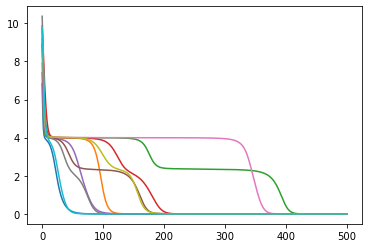

In [145]:
for distance in distances:
  plt.plot(np.real(distance))
for i in range(10):
  print("distance:", implementations[i].distance.round(6).real, "; time:", implementations[i].time.round(2))

In [146]:
implementations[3].save_params("SWAP.txt")